<a href="https://colab.research.google.com/github/smaciasg/Ejercicios_DataScience_Coding_Dojo/blob/main/Belt_Exam_predecir_la_ocupaci%C3%B3n_de_la_una%20oficina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Detección de ocupación
Requisitos:
Tu tarea es predecir si una sala de oficina está desocupada o no, basándote en ciertas medidas incluidas en el conjunto de datos.

Asegúrate de:

* Limpiar los datos.
* Explorar los datos (debes incluir al menos 2 visualizaciones)
* Crear un modelo para predecir si una sala de oficina está ocupada (1) o no (0)
* Debes construir el modelo más preciso que puedas. Asegúrate de validar tu modelo utilizando un conjunto de prueba y entrenamiento.
* Debes poder justificar por qué elegiste el modelo que utilizaste.
* Esto puede implicar probar varios modelos y determinar el mejor, o ser capaz de explicar y justificar racionalmente tu elección.

**Diccionario de datos:**

**Nombre columna	Tipo de dato	Descripción**

Occupancy	Int	Ocupación de la habitación (0 = no ocupada, 1 = ocupada) (objetivo)

date	Objeto	Fecha hora (año-mes-día hora:minuto:segundo)

Temperature	Flotante	Temperatura ambiente en grados Celsius

Humidity	Flotante	Humedad relativa %

Light	Flotante	Luz en Lux

CO2	Flotante	CO2 en ppm

HumidityRatio	Flotante	Cantidad derivada de la temperatura y la humedad relativa en kg agua-vapor/kg-aire


###**1) Importar las librerías necesarias**

Dado que es un problema de clasificación, se importan los modelos para tal tipo de caso

In [375]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#Librerías para preprocesamiento
import sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
#Librerías para modelos de selección
from sklearn.model_selection import train_test_split
#Librería para el modelos
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#Librería para las métricas
from sklearn.metrics import accuracy_score, recall_score, precision_score,roc_auc_score,RocCurveDisplay
from sklearn.metrics import classification_report, plot_confusion_matrix
#Para optimizar
from sklearn.model_selection import GridSearchCV

###**2) Cargar datos y explorar**

In [376]:
df_ocupacion = pd.read_csv('/content/drive/MyDrive/CODING DOJO/DATA SCIENCE/BELT EXAM 2/occupancy.csv')
df_ocupacion.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
1,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
2,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
3,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
4,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


**Explorar los datos**

In [377]:
df_ocupacion.info()
#Se observa que no hay datos faltantes, la fecha es un tipo objeto y la columna objetivo que es la Occupancy ya es tipo numérico

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8143 entries, 0 to 8142
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           8143 non-null   object 
 1   Temperature    8143 non-null   float64
 2   Humidity       8143 non-null   float64
 3   Light          8143 non-null   float64
 4   CO2            8143 non-null   float64
 5   HumidityRatio  8143 non-null   float64
 6   Occupancy      8143 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 445.4+ KB


In [378]:
df_ocupacion['Occupancy'].value_counts(normalize=True)
#Se observa que hay un desbalance en el conjunto de datos; por tanto, sería viable usar una regresión logística y validar el parámetro del peso de cada uno de los 
# datos con el fin de mejorar las métricas al menos reducir los negativos.

0    0.78767
1    0.21233
Name: Occupancy, dtype: float64

In [379]:
#Vamos a identificar si hay algún tipo de dato anormal
df_ocupacion.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000
mean,20.619084,25.731507,119.519375,606.546243,0.003863,0.212330
std,1.016916,5.531211,194.755805,314.320877,0.000852,0.408982
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,19.700000,20.200000,0.000000,439.000000,0.003078,0.000000
50%,20.390000,26.222500,0.000000,453.500000,0.003801,0.000000
75%,21.390000,30.533333,256.375000,638.833333,0.004352,0.000000
max,23.180000,39.117500,1546.333333,2028.500000,0.006476,1.000000


**Hallazgos:**

1. La temperatura está dentro de rango adecuados.

2. La humedad podría llegar al 60%, siendo lo agradable, entre 40% y 60%, así que se puede considerar normal

La carencia de humedad (<40%) puede provocar sequedad de ojos, piel y mucosas. Además, aumenta el riesgo de contagio por infecciones respiratorias como el catarro, la gripe o la bronquiolitis (https://www.fisiorespiracion.es/blog/humedad-ideal-en-casa/#:~:text=Hay%20dos%20vías%20para%20mantener,Humidificar%20el%20ambiente.).

Parece ser que hay una relación directa entre la humedad relativa y el bienestar sicológico de los humanos. La humedad relativa a la que mejor nos encontramos los humanos es a un 40% o más. (https://www.lenntech.es/calculadoras/humedad/humedad-relativa.htm)

Esto da a pensar que hay un problema con la humedad de la locación o la medida o definitivamente es un lugar muy seco, por que muchos datos se concentran un porcentajes cercanos al 26%, así que es una oficina que podría afectar a quien la ocupa, podría ser causal que sea ocupada tan poco, pero se podría validar, así que sería necesario un humidificador.

Para oficnas la humedad relativa debería estar cerca al 50% para evitar problemas eléctricos. (https://www.quironprevencion.com/blogs/es/prevenidos/temperatura-oficina-ideal#:~:text=Humedad%20del%20aire%20ideal,aparición%20de%20este%20molesto%20fenómeno.)

3. La luz presenta valores que se deben revisar dado que se encuentra que para una oficia los lux conforatables sería 500lux-750lux y vemos que la mayoría de los datos son cero y hay otros muy elevados, que podrían indicar que la luz natural ilumina directamente el lugar y en esas horas del día se hace la medición. (https://www.philips.es/c-f/XC000002361/¿qué-es-un-lux#:~:text=Una%20vela%20a%201%20metro,lux%20en%20un%20día%20soleado.) , (https://espaciosolar.com/luz-natural/#:~:text=De%20acuerdo%20a%20la%20Norma,de%20baño%2C%20garajes%20y%20almacenes.)
, (https://faro.es/es/blog/una-correcta-iluminacion-en-la-oficina/#:~:text=Cantidad%20de%20luz,-Además%2C%20de%20la&text=Según%20la%20normativa%20vigente%2C%20las,diario%20de%20una%20forma%20cómoda.)

Podría ser que las lux son tan bajas porque hay problemas eléctricos frecuentes debido a la humedad no adecuada del lugar, podría ser un aire acondicionado mal regulado.

4. La concentración de CO2 aceptable está entre 600-800 ppm, hasta los 1000 ppm es aceptable, en un lugar de trabajo el límite máximo serían de 5000 ppm. Así que la oficina en la mayoría de los casos está con concentraciones de CO2 adecuadas, siendo la mediana 453 ppm un valor mur cercano al CO2 exterior, lo que refuerza la idea que la habitación no es muy frecuentada o por pocas personas . (https://www.solerpalau.com/es-es/blog/sensor-co2/)

**Creación de nuevas columnas**

Con el fin de ver la incidencia del tiempo en días, meses, años y horas del día se crean las columnas: Año, mes, día, hora

In [380]:
df_ocupacion['date_data'] = pd.to_datetime(df_ocupacion['date'])

In [381]:
#Ahora vamos a crear una variable numérica para los días y las horas
from datetime import datetime
import time
lista_date_numerico = []
for data in range(len(df_ocupacion)):
  dt = df_ocupacion['date_data'][data]
  timestamp = time. mktime(dt. timetuple()) + dt.microsecond/1e6
  lista_date_numerico.append(timestamp)

df_ocupacion['data_numero'] = lista_date_numerico

In [382]:
#Obtenemos las horas del día
lista_horas = []
lista_horas_min_militar = []
lista_mes = []
lista_dia = []
lista_anio = []
for horas in range(len(df_ocupacion)):
  lista_horas.append(df_ocupacion['date_data'][horas].hour)
  lista_horas_min_militar.append(((df_ocupacion['date_data'][horas].hour)*60)+(df_ocupacion['date_data'][horas].minute))
  lista_dia.append(df_ocupacion['date_data'][horas].day)
  lista_mes.append(df_ocupacion['date_data'][horas].month)
  lista_anio.append(df_ocupacion['date_data'][horas].year)


df_ocupacion['hora_dia'] = lista_horas
df_ocupacion['hora_min_militar'] = lista_horas_min_militar
df_ocupacion['mes'] = lista_mes
df_ocupacion['dia'] = lista_dia
df_ocupacion['anio'] = lista_anio

In [383]:
df_ocupacion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8143 entries, 0 to 8142
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              8143 non-null   object        
 1   Temperature       8143 non-null   float64       
 2   Humidity          8143 non-null   float64       
 3   Light             8143 non-null   float64       
 4   CO2               8143 non-null   float64       
 5   HumidityRatio     8143 non-null   float64       
 6   Occupancy         8143 non-null   int64         
 7   date_data         8143 non-null   datetime64[ns]
 8   data_numero       8143 non-null   float64       
 9   hora_dia          8143 non-null   int64         
 10  hora_min_militar  8143 non-null   int64         
 11  mes               8143 non-null   int64         
 12  dia               8143 non-null   int64         
 13  anio              8143 non-null   int64         
dtypes: datetime64[ns](1), fl

In [384]:
df_ocupacion.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,data_numero,hora_dia,hora_min_militar,mes,dia,anio
count,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8.143000e+03,8143.000000,8143.000000,8143.0,8143.000000,8143.0
mean,20.619084,25.731507,119.519375,606.546243,0.003863,0.212330,1.423317e+09,11.390642,712.932826,2.0,7.075525,2015.0
std,1.016916,5.531211,194.755805,314.320877,0.000852,0.408982,1.410496e+05,7.092195,425.946623,0.0,1.674896,0.0
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000,1.423072e+09,0.000000,0.000000,2.0,4.000000,2015.0
25%,19.700000,20.200000,0.000000,439.000000,0.003078,0.000000,1.423194e+09,5.000000,338.000000,2.0,6.000000,2015.0
50%,20.390000,26.222500,0.000000,453.500000,0.003801,0.000000,1.423317e+09,11.000000,698.000000,2.0,7.000000,2015.0
75%,21.390000,30.533333,256.375000,638.833333,0.004352,0.000000,1.423439e+09,18.000000,1100.000000,2.0,8.000000,2015.0
max,23.180000,39.117500,1546.333333,2028.500000,0.006476,1.000000,1.423561e+09,23.000000,1438.000000,2.0,10.000000,2015.0


En vista de lo anterior:

1. Se va a borrar la columna de date tipo objeto.
2. Se borra la columna de año
3. Se borra la columna de mes
4. Se deja la de data_numero, hora_dia y hora_min_militar

In [385]:
df_ocupacion = df_ocupacion.drop(columns=['anio','mes'])

In [386]:
df_ocupacion.columns

Index(['date', 'Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio',
       'Occupancy', 'date_data', 'data_numero', 'hora_dia', 'hora_min_militar',
       'dia'],
      dtype='object')

In [387]:
df_ocupacion2 = df_ocupacion[['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio','Occupancy','hora_dia', 'dia']].copy()

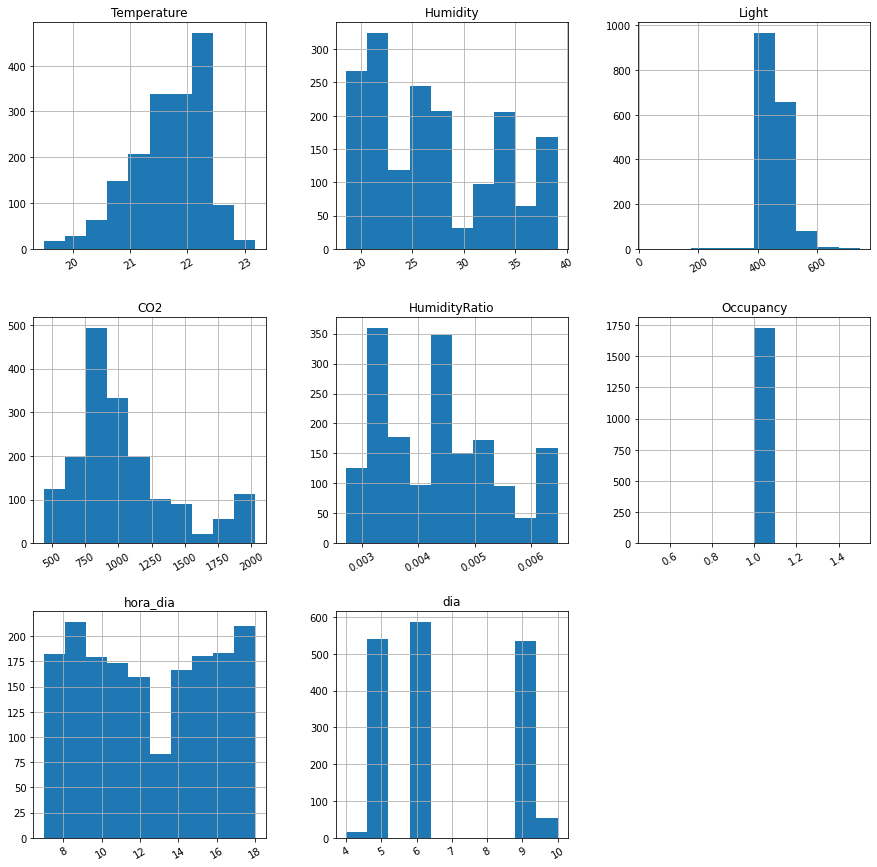

In [388]:
import seaborn as sns
df_ocupacion2[df_ocupacion2['Occupancy']==1].hist(figsize=(15,15), xrot = 30)
plt.show()

**Mapa de calor para identificar la correlación entre variables**

In [389]:
var_corr = df_ocupacion.corr()

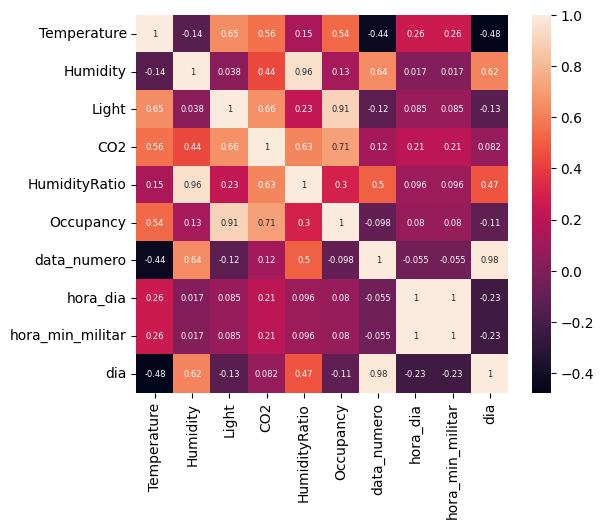

In [390]:
plt.figure(dpi = 100, figsize=(6,5))
sns.heatmap(var_corr,annot=True,annot_kws={"size": 6 })

* Se observa que, si bien no hay una relación altamente fuerte entre las variables características, si hay cierta relación por ejemplo de la temperatura con la luz y el CO2 y en cieta medida con el día.
* La humedad guarda cierta relación con el día y el CO2.
* Las columnas creadas podrían no llegar a aportar al modelo, dada la baja relación observada entre la variable objetivo y estas características.

In [391]:
df_ocupacion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8143 entries, 0 to 8142
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              8143 non-null   object        
 1   Temperature       8143 non-null   float64       
 2   Humidity          8143 non-null   float64       
 3   Light             8143 non-null   float64       
 4   CO2               8143 non-null   float64       
 5   HumidityRatio     8143 non-null   float64       
 6   Occupancy         8143 non-null   int64         
 7   date_data         8143 non-null   datetime64[ns]
 8   data_numero       8143 non-null   float64       
 9   hora_dia          8143 non-null   int64         
 10  hora_min_militar  8143 non-null   int64         
 11  dia               8143 non-null   int64         
dtypes: datetime64[ns](1), float64(6), int64(4), object(1)
memory usage: 763.5+ KB


###**3) Crear matriz de características y vector objetivo**

In [392]:
X = df_ocupacion.drop(columns=['date','date_data','Occupancy'])
y = df_ocupacion['Occupancy']
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

###**4) Instanciar el transformador, modelo (regresión logística inicialmente), pipeline**

**Instancia para el escalador**

In [393]:
scaler = StandardScaler()

**Instancia para el modelo de regresión logística**

In [394]:
log_reg_ocupacion = LogisticRegression(random_state=42)

**Instancia para pipeline**

In [395]:
log_reg_pipe = make_pipeline(scaler,log_reg_ocupacion)

###**5) Ajustar modelo a los datos de entrenamiento**

In [396]:
log_reg_pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(random_state=42))])

###**6) Calcular las predicciones**

In [397]:
log_reg_predic = log_reg_pipe.predict(X_test)
log_reg_predic

array([0, 0, 0, ..., 0, 0, 0])

###**7) Métricas para el modelo**

**Exactitud - Accuracy**

In [398]:
accuracy_train_logreg = log_reg_pipe.score(X_train,y_train)
accuracy_test_log_reg = log_reg_pipe.score(X_test,y_test)
print(f'El accuracy de entrenamiento es: {accuracy_train_logreg}\nEl accuracy de prueba es: {accuracy_test_log_reg}')

El accuracy de entrenamiento es: 0.9862452922875389
El accuracy de prueba es: 0.9852652259332023


**Matriz de confusión**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


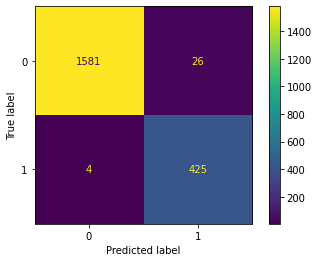

In [399]:
plot_confusion_matrix(log_reg_pipe,X_test,y_test)

**Otras métricas**

In [400]:
print(classification_report(y_test,log_reg_predic))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1607
           1       0.94      0.99      0.97       429

    accuracy                           0.99      2036
   macro avg       0.97      0.99      0.98      2036
weighted avg       0.99      0.99      0.99      2036



**AUC ROC**

In [401]:
print(f'AUC entrenamiento: {roc_auc_score(y_train, log_reg_pipe.predict_proba(X_train)[:,1])}')
print(f'AUC pruebas: {roc_auc_score(y_test, log_reg_pipe.predict_proba(X_test)[:,1])}')

AUC entrenamiento: 0.9943049399113473
AUC pruebas: 0.994295063990148


**Curva AUC_ROC**

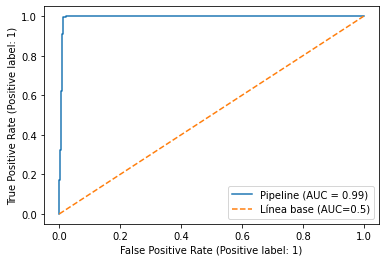

In [402]:
RocCurveDisplay.from_estimator(log_reg_pipe,X_train,y_train)
plt.plot([0,1],[0,1],ls='--', label='Línea base (AUC=0.5)')
plt.legend()

##**PRUEBAS DE OTROS MODELOS**

###**MODELO: Bosque aleatorio**

In [403]:
#**Instanciar el modelo de bosque aleatorio sin ningún hiperparámnetro**
arbol_aleatorio = RandomForestClassifier(random_state=42)
#**Crear pipeline**
arbol_aleatorio_pipe = make_pipeline(scaler,arbol_aleatorio)
#**Ajustar modelo a los datos de entrenamiento**
arbol_aleatorio_pipe.fit(X_train,y_train)
#**Predecir valores**
tree_precitiones = arbol_aleatorio_pipe.predict(X_test)

**Exactitud - Accuracy**

In [404]:
accuracy_train_tree = arbol_aleatorio_pipe.score(X_train,y_train)
accuracy_test_tree = arbol_aleatorio_pipe.score(X_test,y_test)
print(f'El accuracy de entrenamiento es: {accuracy_train_tree}\nEl accuracy de prueba es: {accuracy_test_tree}')

El accuracy de entrenamiento es: 1.0
El accuracy de prueba es: 0.9980353634577603


**Matriz de confusión**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


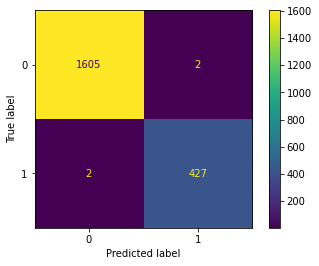

In [405]:
plot_confusion_matrix(arbol_aleatorio_pipe,X_test,y_test)

**Otras métricas**

In [406]:
print(classification_report(y_test,tree_precitiones))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1607
           1       1.00      1.00      1.00       429

    accuracy                           1.00      2036
   macro avg       1.00      1.00      1.00      2036
weighted avg       1.00      1.00      1.00      2036



**AUC ROC**

In [407]:
print(f'AUC entrenamiento: {roc_auc_score(y_train, arbol_aleatorio_pipe.predict_proba(X_train)[:,1])}')
print(f'AUC pruebas: {roc_auc_score(y_test, arbol_aleatorio_pipe.predict_proba(X_test)[:,1])}')

AUC entrenamiento: 1.0
AUC pruebas: 0.999953583027634


###**MODELO: KNN**

In [408]:
#**Instanciar el modelo de bosque aleatorio sin ningún hiperparámnetro**
knn_ocupa = KNeighborsClassifier()
#**Crear pipeline**
ocupacion_knn_pipe = make_pipeline(scaler,knn_ocupa)
#**Ajustar modelo a los datos de entrenamiento**
ocupacion_knn_pipe.fit(X_train,y_train)
#**Predecir valores**
knn_precitiones = ocupacion_knn_pipe.predict(X_test)

**Exactitud - Accuracy**

In [409]:
accuracy_train_knn = ocupacion_knn_pipe.score(X_train,y_train)
accuracy_test_knn = ocupacion_knn_pipe.score(X_test,y_test)
print(f'El accuracy de entrenamiento es: {accuracy_train_knn}\nEl accuracy de prueba es: {accuracy_test_knn}')

El accuracy de entrenamiento es: 0.9952513509087932
El accuracy de prueba es: 0.9950884086444007


**Matriz de confusión**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


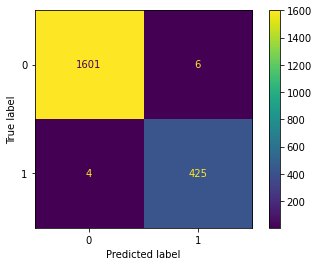

In [410]:
plot_confusion_matrix(ocupacion_knn_pipe,X_test,y_test)

**Otras métricas**

In [411]:
print(classification_report(y_test,knn_precitiones))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1607
           1       0.99      0.99      0.99       429

    accuracy                           1.00      2036
   macro avg       0.99      0.99      0.99      2036
weighted avg       1.00      1.00      1.00      2036



**AUC ROC**

In [412]:
print(f'AUC entrenamiento: {roc_auc_score(y_train, ocupacion_knn_pipe.predict_proba(X_train)[:,1])}')
print(f'AUC pruebas: {roc_auc_score(y_test, ocupacion_knn_pipe.predict_proba(X_test)[:,1])}')

AUC entrenamiento: 0.99991174729161
AUC pruebas: 0.9998991881381427


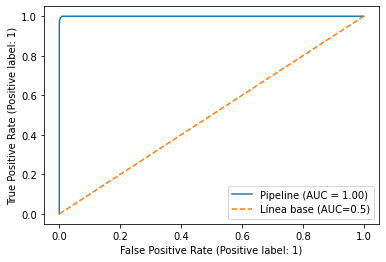

In [413]:
RocCurveDisplay.from_estimator(ocupacion_knn_pipe,X_train,y_train)
plt.plot([0,1],[0,1],ls='--', label='Línea base (AUC=0.5)')
plt.legend()

##**PRUEBA SIN LIMPIEZA DE DATOS**

Tal como se indicó antes las columnas creadas para representación numérica de la fecha, la hora, el día no tenían una alta correlación con el objetivo, decidí repetir el análisis para validar esta idea.

In [414]:
df_ocupacion3 = pd.read_csv('/content/drive/MyDrive/CODING DOJO/DATA SCIENCE/BELT EXAM 2/occupancy.csv')
df_ocupacion3.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
1,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
2,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
3,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
4,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [415]:
#**Crear la matriz de caracteríticas y el vector objetivo**
X1 = df_ocupacion3.drop(columns=['date','Occupancy'])
y1 = df_ocupacion3['Occupancy']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1,y1,random_state=42)

**MODELO KNN**

In [416]:
#**Instanciar el modelo de bosque aleatorio sin ningún hiperparámnetro**
knn_ocupa1 = KNeighborsClassifier()
#**Crear pipeline**
ocupacion_knn_pipe1 = make_pipeline(scaler,knn_ocupa1)
#**Ajustar modelo a los datos de entrenamiento**
ocupacion_knn_pipe1.fit(X_train1,y_train1)
#**Predecir valores**
knn_precitiones1 = ocupacion_knn_pipe1.predict(X_test1)
#Accuracy
accuracy_train_knn1 = ocupacion_knn_pipe1.score(X_train1,y_train1)
accuracy_test_knn1 = ocupacion_knn_pipe1.score(X_test1,y_test1)
print(f'El accuracy de entrenamiento es: {accuracy_train_knn1}\nEl accuracy de prueba es: {accuracy_test_knn1}')

El accuracy de entrenamiento es: 0.9949238578680203
El accuracy de prueba es: 0.9950884086444007


In [417]:
print(f'AUC entrenamiento: {roc_auc_score(y_train1, ocupacion_knn_pipe1.predict_proba(X_train1)[:,1])}')
print(f'AUC pruebas: {roc_auc_score(y_test1, ocupacion_knn_pipe1.predict_proba(X_test1)[:,1])}')

AUC entrenamiento: 0.9998937446992366
AUC pruebas: 0.9999020891989155


**MODELO BOSQUE ALEATORIO PARA CLASIFICACIÓN**

In [418]:
#**Instanciar el modelo de bosque aleatorio sin ningún hiperparámnetro**
arbol_aleatorio1 = RandomForestClassifier(random_state=42)
#**Crear pipeline**
arbol_aleatorio_pipe1 = make_pipeline(scaler,arbol_aleatorio1)
#**Ajustar modelo a los datos de entrenamiento**
arbol_aleatorio_pipe1.fit(X_train1,y_train1)
#**Predecir valores**
tree_precitiones1 = arbol_aleatorio_pipe1.predict(X_test1)
#Accuracy
accuracy_train_tree1 = arbol_aleatorio_pipe1.score(X_train1,y_train1)
accuracy_test_tree1 = arbol_aleatorio_pipe1.score(X_test1,y_test1)
print(f'El accuracy de entrenamiento es: {accuracy_train_tree1}\nEl accuracy de prueba es: {accuracy_test_tree1}')

El accuracy de entrenamiento es: 1.0
El accuracy de prueba es: 0.9965618860510805


In [419]:
print(f'AUC entrenamiento: {roc_auc_score(y_train1, arbol_aleatorio_pipe1.predict_proba(X_train1)[:,1])}')
print(f'AUC pruebas: {roc_auc_score(y_test1, arbol_aleatorio_pipe1.predict_proba(X_test1)[:,1])}')

AUC entrenamiento: 1.0
AUC pruebas: 0.9999202208287461


**MODELO REGRESIÓN LOGÍSTICA**

In [420]:
#**Instanciar el modelo de bosque aleatorio sin ningún hiperparámnetro**
log_reg_ocupacion1 = LogisticRegression(random_state=42)
#**Crear pipeline**
log_reg_pipe1 = make_pipeline(scaler,log_reg_ocupacion1)
#**Ajustar modelo a los datos de entrenamiento**
log_reg_pipe1.fit(X_train1, y_train1)
#**Predecir valores**
log_reg_predic1 = log_reg_pipe1.predict(X_test1)
#Accuracy
accuracy_train_logreg1 = log_reg_pipe1.score(X_train1,y_train1)
accuracy_test_log_reg1 = log_reg_pipe1.score(X_test1,y_test1)
print(f'El accuracy de entrenamiento es: {accuracy_train_logreg1}\nEl accuracy de prueba es: {accuracy_test_log_reg1}')

El accuracy de entrenamiento es: 0.9864090388079253
El accuracy de prueba es: 0.9852652259332023


In [421]:
print(f'AUC entrenamiento: {roc_auc_score(y_train1, log_reg_pipe1.predict_proba(X_train1)[:,1])}')
print(f'AUC pruebas: {roc_auc_score(y_test1, log_reg_pipe1.predict_proba(X_test1)[:,1])}')

AUC entrenamiento: 0.994402874013858
AUC pruebas: 0.9946663997690756


#**Conclusiones:**

1. Finalmente el desbalance del conjunto de datos parace no afectar la predicción realizada.
2. La regresión logística sin ajustes de hiperparámetro y regularización cumple de manera adecuada con el objetivo de la predicción.
3. Las métricas son adecuadas, me preocupaban los falsos positivos y negativos, pero el desempeño general fue el adecuado para la necesidad del modelo.
4. Luego de probar los modelos KNN y árboles de clasificación, se observa que ambos sin necesidad de ajustar hiperparámetros tiene un muy buen desempeño; aún así, la menor cantidad de falsos negativos y positivos los tiene el árbol de clasificación; por tanto, eligiría cualquiera de los método acá expuestos, la única razón para no aceptar el árbol de clasificación sería que se ajusta el 100% al conjunto de entrenamiento, pero tambíen al de prueba, así que para este caso funciona de forma adecuada.
5. Finalmente, deseé probar si los cambios que hice en el dataset realmente afectaban el desempeño de los modelos en especial el AUC ROC, pero es claro que no, solo retirando las fechas es suficiente para que el modelo capture los patrones existentes entre las variables otorgadas originalmente en el dataset, dado que el valor numérico de la fecha tenía una.